In [39]:
import pandas as pd
import numpy as np
import re # not really used atm
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [40]:
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score
# from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import StratifiedKFold # for cross validation

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras


In [41]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [42]:
def check_null(df):
    print('\ncheck null values \n')
    print('shape df: ', df.shape, '\n')
    ok_columns = [col for col in df if df[col].isna().sum() == 0]
    print('ok columns: ', ok_columns, '\n')
    for col in df:
        if df[col].isna().sum() >0:
            print(col, ':', df[col].isna().sum())

In [43]:
df_original = pd.read_csv('../input/output.csv')

In [44]:
df_original.head(3)

,name,flav,truth_match,quark_match,ele_match,PU_frac,jet_pt,jet_eta,n_trk,ValZ0_0,SigZ0_0,ValD0_0,SigZ0_0.1,IP3D_trk_pb_0,IP3D_trk_pu_0,IP3D_trk_pc_0,pt_trk_0,has_time_0,time_0,nhits_0,has_time_truth_0,time_truth_0,nhits_truth_0,ValZ0_1,SigZ0_1,ValD0_1,SigZ0_1.1,IP3D_trk_pb_1,IP3D_trk_pu_1,IP3D_trk_pc_1,...,ValZ0_24,SigZ0_24,ValD0_24,SigZ0_24.1,IP3D_trk_pb_24,IP3D_trk_pu_24,IP3D_trk_pc_24,pt_trk_24,has_time_24,time_24,nhits_24,has_time_truth_24,time_truth_24,nhits_truth_24,IP3Dw,SV1w,JFw,JFCombNNw,Mv2w,Mv1w,IP3DPlusSV1w,has_t0,t0,zero,has_t0_alex,event_t0_alex,event_sigma_t0_alex,has_t0_truth_alex,event_t0_truth_alex,event_sigma_t0_truth_alex
0,chiara,5,1,1,1,0,89.1850,2.41618,3,0.002925,0.164238,0.081468,0.164238,0.301763,0.337918,0.360319,14.67270,0,-999.000000,-999,0,-999.000000,-999,-0.176481,-3.117790,-0.049532,-3.117790,0.238208,0.355278,0.406513,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.189330,-21.0,-2.923830,-3.27382,-0.917515,0.055535,-2.73933,1,-0.228584,0,1,-0.243049,0.009707,1,-0.254928,0.012374
1,chiara,4,1,0,0,0.256909,29.6345,2.81383,11,0.030487,1.321540,0.010465,1.321540,0.227965,0.408232,0.363803,6.56534,1,-0.251698,2,1,-0.254928,2,0.000953,0.028719,0.037505,0.028719,0.205136,0.456420,0.338444,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.737090,-21.0,0.758073,-1.95161,-0.905753,0.055535,-3.28709,1,-0.228584,0,1,-0.243049,0.009707,1,-0.254928,0.012374
2,chiara,15,1,0,0,0,38.0020,2.43809,2,0.011517,0.504596,0.028516,0.504596,0.235433,0.413230,0.351337,9.64379,1,0.106788,2,1,0.110633,2,-0.080660,-3.985880,-0.021664,-3.985880,0.238208,0.355278,0.406513,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.962335,-21.0,-41.000000,-4.38596,-0.949058,0.055535,-2.51233,2,0.103382,0,1,0.121020,0.007298,1,0.112419,0.006093


In [45]:
# define some useful variables
use_t0 = 1
use_truth = 0
n_trk_used = 10
tagger = 'IP3D_tracks' # d0z0_traks, IP3D_tracks, IP3Dw, SV1w, JFw, JFCombNNw, Mv2w, Mv1w, IP3DPlusSV1w
manipulate_time = 1
train_ITK = 1


In [46]:
time_str = 'time' # string to read the time of each track
nhits_str = 'nhits'
#t0_variables = ['has_t0','t0','zero'] # my simple t0
t0_variables = ['has_t0_alex','event_t0_alex','event_sigma_t0_alex'] # BDT t0 reco

if use_truth:
    time_str = 'time_truth' 
    nhits_str = 'nhits_truth'
    t0_variables = ['has_t0_truth_alex','event_t0_truth_alex','event_sigma_t0_truth_alex'] # BDT t0 rec

columns_to_use = dict()
columns_to_use['IP3Dw'] = ['IP3Dw']
columns_to_use['SV1w'] = ['SV1w']
columns_to_use['JFw'] = ['JFw']
columns_to_use['JFCombNNw'] = ['JFCombNNw']
columns_to_use['Mv2w'] = ['Mv2w']
columns_to_use['Mv1w'] = ['Mv1w']
columns_to_use['IP3DPlusSV1w'] = ['IP3DPlusSV1w']
columns_to_use['IP3D_tracks'] = [info+'_'+str(i) for i in range(n_trk_used) for info in ["IP3D_trk_pb","IP3D_trk_pu"]]
columns_to_use['d0z0_traks'] = [info+'_'+str(i) for i in range(n_trk_used) for info in ["ValZ0","SigZ0","ValD0","SigZ0"]]
# info currently not used: "IP3D_trk_pc","pt_trk"
info_from_HGTD = [info+'_'+str(i) for i in range(n_trk_used) for info in ["has_"+time_str, time_str,nhits_str]]
if use_t0:
    info_from_HGTD = info_from_HGTD + t0_variables

In [47]:
# remove rows with NaN (originating e.g. from empty lines in input file)
df_original = df_original[df_original['flav'].notna()] 

In [48]:
# check_null(df)

In [49]:
# do not consider PU jets
df = df_original[(df_original['truth_match']>0) & (df_original['quark_match']>0)]
# keep jets with pt>20 GeV, 2.5<eta<4
df = df[(df['jet_pt']>20) & (df['jet_eta']>2.4) & (df['jet_eta']<4)]
#df = df_original[(df_original['ele_match']<1)]
# for the moment I want to focus on b-vs-light --> keep only real light and b, and put target to flav=5
df = df[(df['flav']==0) | (df['flav']==5) ]
df['target'] = (df['flav'] == 5 ).astype(int)

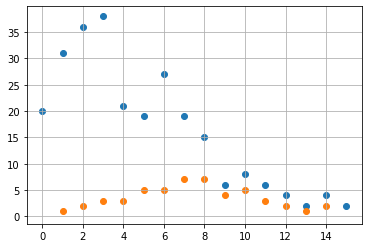

In [50]:
plt.scatter(df_original['n_trk'].value_counts().index, df_original['n_trk'].value_counts())
plt.scatter(df['n_trk'].value_counts().index, df['n_trk'].value_counts())
plt.grid(True)

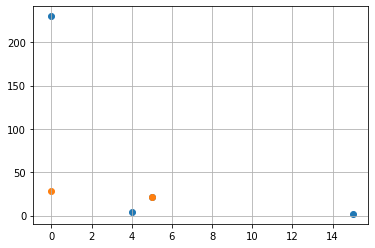

In [51]:
plt.scatter(df_original['flav'].value_counts().index, df_original['flav'].value_counts())
plt.scatter(df['flav'].value_counts().index, df['flav'].value_counts())
plt.grid(True)

In [52]:
# df[['truth_match','quark_match','ele_match']].describe()

In [53]:
# check how many events and the fraction of b-jets
df['target'].describe()

count    50.000000
mean     0.440000 
std      0.501427 
min      0.000000 
25%      0.000000 
50%      0.000000 
75%      1.000000 
max      1.000000 
Name: target, dtype: float64

In [54]:
df = df.replace([-999],[0])

In [55]:
# change the track pT into fraction of the jet_pt
for i in range(25):
    col = 'pt_trk'+'_'+str(i)
    df[col] = df[col]/df['jet_pt']

In [56]:
# change time into time-t0 (if no t0, t0 is set to zero so no difference)
if manipulate_time:
    df['avg_trk_time'] = 0
    df.loc[df['n_trk']>0,'avg_trk_time'] = (sum(df[time_str+'_'+str(i)] for i in range(25)))/df['n_trk']
    for i in range(25):
        if use_t0:
            col = time_str+'_'+str(i)
            df[col] = df[col]-df['t0']
            df.loc[df['has_t0']<1,'time'+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']
        else:
            df['time'+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']

In [57]:
#check_null(df)

In [58]:
# df[['flav']+['pt_trk'+'_'+str(i) for i in range(n_trk_used)]].head()
# pfff, these are not pt ordered :( Probably pt-ordeered before calibration

In [59]:
columns_to_use_df = ['target'] + columns_to_use[tagger] + info_from_HGTD
df_to_use = df[columns_to_use_df]

In [60]:
#columns_to_use.remove('target')
# columns_to_use

In [61]:
# convert df into arrays
X = df_to_use[columns_to_use[tagger] + info_from_HGTD].values
y = df_to_use['target'].values
# scaling
sc = StandardScaler()
X = sc.fit_transform(X) 

In [62]:
# cross validation 
cv = StratifiedKFold(n_splits=6)
tprs_itk = []
aucs_itk = []
mean_fpr_itk = np.linspace(0, 1, 100)


In [63]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [64]:
# Neural network
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(300, input_dim=len(columns_to_use[tagger]+info_from_HGTD), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
 # it was 100 epochs
                     # show accuracy on test data after every epoch

Train on 41 samples, validate on 9 samples
Epoch 1/10
41/41 [==============================] - 0s 131us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/10
41/41 [==============================] - 0s 146us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 3/10
41/41 [==============================] - 0s 150us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4/10
41/41 [==============================] - 0s 127us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 5/10
41/41 [==============================] - 0s 124us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 6/10
41/41 [==============================] - 0s 126us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 7/10
41/41 [==============================] - 0s 131us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 8/10
41/41 [===============

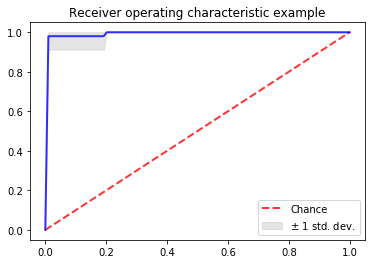

In [72]:
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    history = model.fit(X[train], y[train], epochs=10, batch_size=50,
                        validation_data = (X[test],y[test]))
    y_pred_test = model.predict(X[test])
    fpr_test, tpr_test, thresholds_test = roc_curve(y[test], y_pred_test)
    interp_tpr = np.interp(mean_fpr_itk, fpr_test, tpr_test)
    interp_tpr[0] = 0.0
    tprs_itk.append(interp_tpr)
    #aucs_itk.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr_itk = np.mean(tprs_itk, axis=0)
mean_tpr_itk[-1] = 1.0
#mean_auc_itk = auc(mean_fpr_itk, mean_tpr_itk)
#std_auc_itk = np.std(aucs)
ax.plot(mean_fpr_itk, mean_tpr_itk, color='b',
        #label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_itk, std_auc_itk),
        lw=2, alpha=.8)

std_tpr_itk = np.std(tprs_itk, axis=0)
tprs_upper_itk = np.minimum(mean_tpr_itk + std_tpr_itk, 1)
tprs_lower_itk = np.maximum(mean_tpr_itk - std_tpr_itk, 0)
ax.fill_between(mean_fpr_itk, tprs_lower_itk, tprs_upper_itk, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [26]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


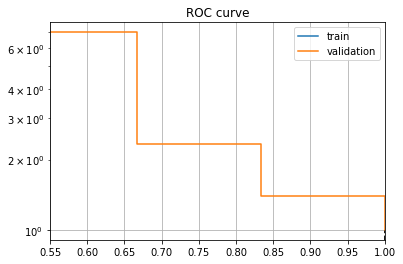

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.xlim(0.55,1)
plt.grid(True)
plt.show()

In [28]:
type(X_train)

numpy.ndarray

In [29]:
X_train.shape

(37, 53)

In [30]:
X_train_no_HGTD = X_train[:,0:len(columns_to_use[tagger])]
X_test_no_HGTD = X_test[:,0:len(columns_to_use[tagger])]

In [31]:
X_train_no_HGTD.shape

(37, 20)

In [32]:
# Neural network
model2 = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model2.add(Dense(300, input_dim=len(columns_to_use[tagger]), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model2.fit(X_train_no_HGTD, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test_no_HGTD,y_test)) # show accuracy on test data after every epoch

Train on 37 samples, validate on 13 samples
Epoch 1/10
37/37 [==============================] - 1s 16ms/step - loss: 0.6847 - acc: 0.4865 - val_loss: 0.6510 - val_acc: 0.6154
Epoch 2/10
37/37 [==============================] - 0s 115us/step - loss: 0.6488 - acc: 0.7027 - val_loss: 0.6295 - val_acc: 0.7692
Epoch 3/10
37/37 [==============================] - 0s 220us/step - loss: 0.6152 - acc: 0.7568 - val_loss: 0.6099 - val_acc: 0.7692
Epoch 4/10
37/37 [==============================] - 0s 129us/step - loss: 0.5840 - acc: 0.7568 - val_loss: 0.5924 - val_acc: 0.7692
Epoch 5/10
37/37 [==============================] - 0s 132us/step - loss: 0.5549 - acc: 0.8378 - val_loss: 0.5768 - val_acc: 0.7692
Epoch 6/10
37/37 [==============================] - 0s 127us/step - loss: 0.5279 - acc: 0.8649 - val_loss: 0.5630 - val_acc: 0.7692
Epoch 7/10
37/37 [==============================] - 0s 133us/step - loss: 0.5028 - acc: 0.8919 - val_loss: 0.5512 - val_acc: 0.7692
Epoch 8/10
37/37 [===============

In [33]:
# Prediction
y_pred_test_no_HGTD = model2.predict(X_test_no_HGTD)
y_pred_train_no_HGTD = model2.predict(X_train_no_HGTD)

fpr_test_no_HGTD, tpr_test_no_HGTD, thresholds_test_no_HGTD = roc_curve(y_test, y_pred_test_no_HGTD)
fpr_train_no_HGTD, tpr_train_no_HGTD, thresholds_train_no_HGTD = roc_curve(y_train, y_pred_train_no_HGTD)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


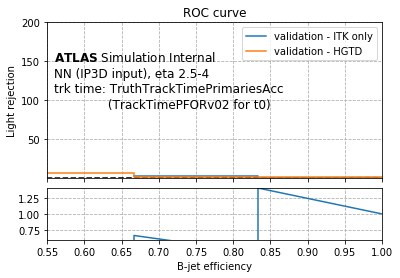

In [34]:
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[3,1],
                       hspace=0.10)
ax1 = plt.subplot(gs[0])

plt.figure(1)
plt.text(0.02, 0.75, r'$\mathbf{ATLAS}$ Simulation Internal', size='large',transform=ax1.transAxes)
plt.text(0.02, 0.65, r'NN (IP3D input), eta 2.5-4', size='large',transform=ax1.transAxes)
plt.text(0.02, 0.55, r'trk time: TruthTrackTimePrimariesAcc', size='large',transform=ax1.transAxes)
plt.text(0.17, 0.45, r' (TrackTimePFORv02 for t0)', size='large',transform=ax1.transAxes)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(tpr_train_no_HGTD, 1./fpr_train_no_HGTD, label='train_no_HGTD')
one_over_fpr_test_no_HGTD = 1./fpr_test_no_HGTD
one_over_fpr_test = 1./fpr_test
plt.plot(tpr_test_no_HGTD, one_over_fpr_test_no_HGTD, label='validation - ITK only')
#plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, one_over_fpr_test, label='validation - HGTD')
plt.ylabel('Light rejection')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(0.55,1)
plt.ylim(1,200)
plt.grid(True,linestyle='--')
plt.gca().set_xticklabels(['']*10)

ax2 = plt.subplot(gs[1])
plt.xlim(0.55,1)
plt.ylim(0.6,1.4)
#np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
one_over_fpr_test_plot = np.interp(tpr_test_no_HGTD, tpr_test, one_over_fpr_test)
ljr_ratio = np.divide(one_over_fpr_test_plot, one_over_fpr_test_no_HGTD)
plt.plot(tpr_test_no_HGTD, ljr_ratio)
plt.grid(True,linestyle='--')
plt.xlabel('B-jet efficiency')

plt.show()